In [1]:
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops
import matplotlib.pyplot as plt

# Medical Image Computing - Exercise 2

Jasmin Eder, Dorothea Mauracher, Sonja Pappenberger

Add Package scikit-image to environment

## Image texture descriptors
#### 1.1 Load the image “breastXray.tif”. Split the image into non-overlapping blocks of 20 x 20 pixels. What is the original image size and hence how many blocks/regions are processed in the following steps?

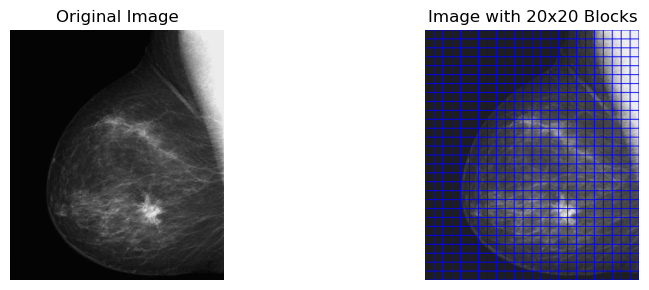

Image width: 480 pixels
Image height: 560 pixels
Total number of blocks in the image: 672


In [2]:
# Read the image
image = cv2.imread("breastXray.tif", cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

# Get size of the image
height, width = image.shape

# Define block size
block_size = 20

# Calculate the number of blocks in both dimensions
blocks_height = height // block_size
blocks_width = width // block_size

# Calculate the total number of blocks
total_blocks = blocks_height * blocks_width

# Split the image into blocks
blocks = []
for i in range(blocks_height):
    for j in range(blocks_width):
        block = image[i * block_size:(i + 1) * block_size, j * block_size:(j + 1) * block_size]
        blocks.append(block)
             
# Create a copy of the image to draw rectangles on
image_with_blocks = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Draw rectangles around each block on the image
for i in range(blocks_height):
    for j in range(blocks_width):
        cv2.rectangle(image_with_blocks, (j * block_size, i * block_size),
                      ((j + 1) * block_size - 1, (i + 1) * block_size - 1), (0, 0, 255), 1)

# Plot the original image
fig, axs = plt.subplots(1, 2, figsize=(10,3))
axs[0].imshow(image, cmap = 'gray')
axs[0].axis('off')
axs[0].set_title('Original Image')
# Plot the split image
axs[1].imshow(image_with_blocks, cmap='gray')
axs[1].axis('off')
axs[1].set_title('Image with 20x20 Blocks')
plt.tight_layout()
plt.show()

print(f"Image width: {width} pixels")
print(f"Image height: {height} pixels")
print(f'Total number of blocks in the image: {total_blocks}')

The original image size is 560 pixel x 480 pixels and the split image has a total of 672 blocks.
    

#### 1.2 Determine the gray level co-occurrence matrix (GLCM) for each region/block using a position operator [Dx, Dy]. Choose a distance, e.g. D = 1, and extract the GLCM at four different directions [0°, 45°, 90°, 135°]. The number of gray levels should be set to 16. What is the size of one GLCM?

In [3]:
# Definitions for GLCM calculation
distance = [1] 
angles = [0, np.pi/4, np.pi/2, 3*np.pi/8]  # Angles in degrees: 0°, 45°, 90°, 135°

# Number of gray levels
gray_levels = 16

# Scale image with 255 gray levels to 16
image_16 = image / 255 * 15
image_16 = image_16.astype(np.uint8)

# Create new blocks with 16 gray levels
blocks_16 = []
for i in range(blocks_height):
    for j in range(blocks_width):
        block = image_16[i * block_size:(i + 1) * block_size, j * block_size:(j + 1) * block_size]
        blocks_16.append(block)

# Calculate GLCM for each block at different angles
glcms = []
glcm_size = None
     
for block in blocks_16:
    glcm = graycomatrix(block, distances=distance, angles=angles, levels=gray_levels, symmetric=True, normed=True)
    glcms.append(glcm)
    if glcm_size is None:
        glcm_size = glcm.shape
   

print(f"Size of one GLCM: {glcm_size}")

Size of one GLCM: (16, 16, 1, 4)


For using a gray level of 16, the image firstly needs to be rescaled from 256 gray levels to 16 gray levels. Therefore a transformation is done to the original image. For later use the datatype needs to be an integer and therefore the image is transformed from a float to an integer type. New blocks with 16 gray levels are created. The size of one GLCM is 16 x 16.

#### 1.3 Calculate the correlation, contrast, energy and homogeneity for each GLCM. Show processed images based on the descriptors, i.e. Correlation at four directions with D = 1, Contrast at four directions with D =1, etc., using subplots (see Figure 1). How many features did you extract? Comment on the differences between the different texture descriptors

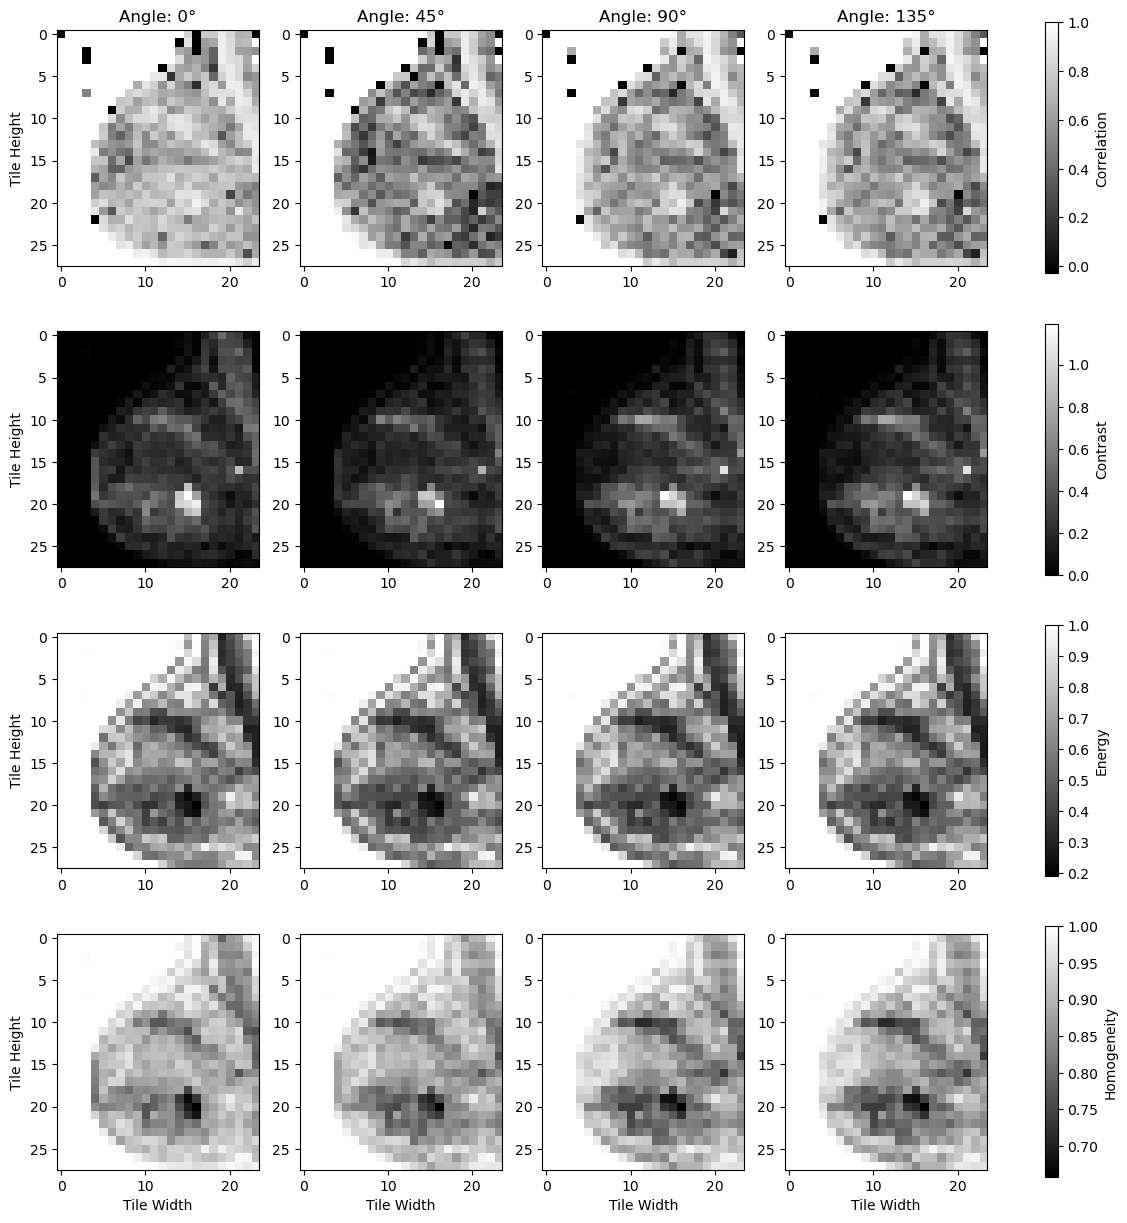

In [4]:
distance = 1
angles = [0, np.pi/4, np.pi/2, 3*np.pi/8]
tile_size = 20 # int(np.sqrt((image.shape[0] * image.shape[1]) / correlation_values_a1.size))

# Calculate features of GLCM
features = []
for glcm in glcms:
    # Calculate GLCM properties
    correlation = graycoprops(glcm, 'correlation')
    contrast = graycoprops(glcm, 'contrast')
    energy = graycoprops(glcm, 'energy')
    homogeneity = graycoprops(glcm, 'homogeneity')
    features.append((correlation, contrast, energy, homogeneity))
# Structure of features list:
# (correlation([[angle1, angle2, angle3, angle4]]), contrast([[angles]]), energy([[angles]]), homogeneity([[angles]]))
# one feature (eg correlation): [[angle1, angle2, angle3, angle4]]    

# Extract features depending on angle
features_a1 = [(arr[0][:, :1], arr[1][:, :1], arr[2][:, :1], arr[3][:, :1]) for arr in features]
features_a2 = [(arr[0][:, 1:2], arr[1][:, 1:2], arr[2][:, 1:2], arr[3][:, 1:2]) for arr in features]
features_a3 = [(arr[0][:, 2:3], arr[1][:, 2:3], arr[2][:, 2:3], arr[3][:, 2:3]) for arr in features]
features_a4 = [(arr[0][:, 3:4], arr[1][:, 3:4], arr[2][:, 3:4], arr[3][:, 3:4]) for arr in features]

# Extract the calculated values
correlation_values_a1, contrast_values_a1, energy_values_a1, homogeneity_values_a1 = zip(*features_a1)
correlation_values_a2, contrast_values_a2, energy_values_a2, homogeneity_values_a2 = zip(*features_a2)
correlation_values_a3, contrast_values_a3, energy_values_a3, homogeneity_values_a3 = zip(*features_a3)
correlation_values_a4, contrast_values_a4, energy_values_a4, homogeneity_values_a4 = zip(*features_a4)

# Convert to numpy arrays
correlation_values_a1, correlation_values_a2, correlation_values_a3, correlation_values_a4 = map(np.array, [correlation_values_a1, correlation_values_a2, correlation_values_a3, correlation_values_a4])
contrast_values_a1, contrast_values_a2, contrast_values_a3, contrast_values_a4 = map(np.array, [contrast_values_a1, contrast_values_a2, contrast_values_a3, contrast_values_a4])
energy_values_a1, energy_values_a2, energy_values_a3, energy_values_a4 = map(np.array, [energy_values_a1, energy_values_a2, energy_values_a3, energy_values_a4])
homogeneity_values_a1, homogeneity_values_a2, homogeneity_values_a3, homogeneity_values_a4 = map(np.array, [homogeneity_values_a1, homogeneity_values_a2, homogeneity_values_a3, homogeneity_values_a4])

# Cluster the values
correlation_values = [correlation_values_a1, correlation_values_a2, correlation_values_a3, correlation_values_a4]
contrast_values = [contrast_values_a1, contrast_values_a2, contrast_values_a3, contrast_values_a4]
energy_values = [energy_values_a1, energy_values_a2, energy_values_a3, energy_values_a4]
homogeneity_values = [homogeneity_values_a1, homogeneity_values_a2, homogeneity_values_a3, homogeneity_values_a4]

# Reshape the images
correlation_images = [values.reshape((image.shape[0] // tile_size, image.shape[1] // tile_size)) for values in correlation_values]
contrast_images = [values.reshape((image.shape[0] // tile_size, image.shape[1] // tile_size)) for values in contrast_values]
energy_images = [values.reshape((image.shape[0] // tile_size, image.shape[1] // tile_size)) for values in energy_values]
homogeneity_images = [values.reshape((image.shape[0] // tile_size, image.shape[1] // tile_size)) for values in homogeneity_values]
all_images = [correlation_images, contrast_images, energy_images, homogeneity_images]

# Plot the images
fig, axs = plt.subplots(4, 4, figsize=(15, 15))

# Feature titles for colorbars
feature_titles = ['Correlation', 'Contrast', 'Energy', 'Homogeneity']

# Iterate over each row (feature type)
for i, feature_type in enumerate(all_images):
    # Iterate over each column (angle)
    for j, feature_image in enumerate(feature_type):
        axs[i, j].imshow(feature_image, cmap='gray', interpolation='nearest')
        if i == 0:
            axs[i, j].set_title(f'Angle: {j * 45}°')

    # Add colorbar at the end of each row
    pos = axs[i, -1].imshow(feature_image, cmap='gray', interpolation='nearest')
    fig.colorbar(pos, ax=axs[i, :], label=feature_titles[i])
    axs[i, 0].set_ylabel('Tile Height')

# Set x-labels for the last row
axs[-1, 0].set_xlabel('Tile Width')
axs[-1, 1].set_xlabel('Tile Width')
axs[-1, 2].set_xlabel('Tile Width')
axs[-1, 3].set_xlabel('Tile Width')

plt.show()

4 features are extracted from 4 different directions resulting in 16 different images. Correlation shows the most differences between the 4 angles. Contrast and Energy seem to be similar but inverted. Homogeneity shows some slight differences between different directions. <br>
<b>Correlation:</b> Calculation of dependencies between neighbour pixels. Brighter regions define higher correlation. <br>
<b>Contrast:</b> Calculation of variations in pixel intensities. Brighter reagions indicate higher variations. <br>
<b>Energy:</b> Calculation of ordered and uniform textures. Brighter reagions represent higher uniformity. <br>
<b>Homogeneity:</b> Calculation of the closeness of element distributio to the diagonal. Bright regions show pixels wwith similar intensities.

#### 1.4 Build a design/data matrix based on your blocks where each block/region is an observation (sample) and the texture descriptors are the features. Normalize the features in the design matrix between 0 and 1. What is the size of your design matrix?

#### 1.5. (BONUS, 1 extra point) Try two different pixel distances D, e.g. 1 and 3, and show the processed images using subplots. Comment on the influence of the distance parameter. Decide for one of the two distances D to be used in the design matrix for the second part of the exercise.

## Texture-based clustering
#### 2.1. Cluster the blocks represented by the design matrix using k-means clustering. Use k=4 and use at least 10 repeats for the initialization

#### 2.2. Visualize the blocks corresponding to the four different labels as an overlay to the original image, i.e. mask the original image with the labels found by the k-means algorithm. Which regions in the image were found? Describe the characteristics of the regions.